#**3d Brain Volume Reconstruction using 3DUnet**

Kaggle Json File Import

In [1]:
from google.colab import files
files.upload()

Saving kaggle-2.json to kaggle-2.json


{'kaggle-2.json': b'{"username":"harshinidonepudi","key":"ab6fdb8e0cbc2befd28c0a4d294f05ab"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Change the permissions of the file.

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


Dataset Download from Kaggle

In [3]:
!kaggle datasets download -d dschettler8845/brats-2021-task1

Dataset URL: https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1
License(s): copyright-authors
100% 12.3G/12.3G [02:28<00:00, 24.8MB/s]
100% 12.3G/12.3G [02:28<00:00, 88.7MB/s]


In [4]:
!unzip -q brats-2021-task1.zip -d ./data

In [ ]:
pip install nibabel albumentations

In [13]:
# define import statements

import tarfile
import os
import numpy as np
import random
import nibabel as nib
import albumentations as A
import plotly
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, BatchNormalization, Activation
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.metrics import Precision, Recall
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


All Functions Used

In [6]:
# Define utility functions for data manipulation, resizing, and normalization

class ImageReader:
    def __init__(self, root:str, img_size:int=256, normalize:bool=False, single_class:bool=False):
        pad_size = 256 if img_size > 256 else 224
        self.resize = A.Compose(
            [
                A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
                A.Resize(img_size, img_size)
            ]
        )
        self.normalize = normalize
        self.single_class = single_class
        self.root = root

    def read_file(self, path:str) -> dict:
        scan_type = path.split('_')[-1]
        raw_image = nib.load(path).get_fdata()
        raw_mask = nib.load(path.replace(scan_type, 'seg.nii.gz')).get_fdata()
        processed_frames, processed_masks = [], []
        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            mask = raw_mask[:, :, frame_idx]
            if self.normalize:
                if frame.max() > 0:
                    frame = frame / frame.max()
                frame = frame.astype(np.float32)
            else:
                frame = frame.astype(np.uint8)
            resized = self.resize(image=frame, mask=mask)
            processed_frames.append(resized['image'])
            processed_masks.append(1 * (resized['mask'] > 0) if self.single_class else resized['mask'])
        return {
            'scan': np.stack(processed_frames, 0),
            'segmentation': np.stack(processed_masks, 0),
            'orig_shape': raw_image.shape
        }

    def load_random_patient_scan(self, scan_type:str='flair') -> dict:
        patient_dirs = [d for d in os.listdir(self.root) if os.path.isdir(os.path.join(self.root, d))]
        if not patient_dirs:
            raise ValueError("No patient directories found in the specified root directory.")
        selected_patient_dir = random.choice(patient_dirs)
        scan_filename = os.path.join(self.root, selected_patient_dir, f'{selected_patient_dir}_{scan_type}.nii.gz')
        if not os.path.exists(scan_filename):
            raise FileNotFoundError(f"No scan file found for the selected patient in scan type {scan_type}.")
        return self.read_file(scan_filename)

class MRISequence(Sequence):
    def __init__(self, image_files, mask_files, batch_size, input_shape):
        self.image_files, self.mask_files = image_files, mask_files
        self.batch_size = batch_size
        self.input_shape = input_shape  # New attribute to store the target input shape

    def __len__(self):
        return np.ceil(len(self.image_files) / self.batch_size).astype(int)

    def __getitem__(self, idx):
        batch_image_files = self.image_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_mask_files = self.mask_files[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = [self._resize_volume(nib.load(file_path).get_fdata()) for file_path in batch_image_files]
        batch_masks = [self._resize_volume(nib.load(file_path).get_fdata(), is_mask=True) for file_path in batch_mask_files]

        batch_images = np.array(batch_images)[..., np.newaxis]  # Add channel dimension
        batch_masks = np.array(batch_masks)[..., np.newaxis]  # Add channel dimension

        return np.array(batch_images), np.array(batch_masks)

    def _resize_volume(self, img, is_mask=False):
        # Calculate the current shape and the target shape
        current_shape = np.array(img.shape)
        target_shape = np.array(self.input_shape)
        # Calculate the zoom factor needed to match the target shape
        zoom_factor = target_shape / current_shape
        # Use interpolation mode 0 (nearest) for masks to avoid creating new classes
        img_resized = zoom(img, zoom_factor, order=0 if is_mask else 3)
        return img_resized

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float32'), axis=-1)
    fp = K.sum(K.cast((1-y_true) * y_pred, 'float32'), axis=-1)
    fn = K.sum(K.cast(y_true * (1-y_pred), 'float32'), axis=-1)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def predict_mask(volume, model):
    """Predict segmentation mask for a single volume using the trained model."""
    # Resize the volume to the input shape expected by the model (128, 128, 64)
    resized_volume = zoom(volume, (128 / volume.shape[0], 128 / volume.shape[1], 64 / volume.shape[2]))

    # Normalize or preprocess your volume as required for your model here
    # Assuming the resized volume is already normalized if necessary

    # Add batch and channel dimensions
    resized_volume = np.expand_dims(resized_volume, axis=0)  # Add batch dimension
    resized_volume = np.expand_dims(resized_volume, axis=-1)  # Add channel dimension

    # Make the prediction
    prediction = model.predict(resized_volume)

    # Remove batch dimension and get the first channel as the predicted mask
    predicted_mask = prediction[0, :, :, :, 0]

    return predicted_mask

def plot_3d_overlay(brain_volume, original_mask, predicted_mask, volume_threshold, mask_threshold=0.2):
    # Preprocess the volumes
    p_brain = brain_volume.transpose(2, 1, 0)
    p_brain = p_brain[:, :, ::-1]

    p_predicted_mask = predicted_mask.transpose(2, 1, 0)
    p_predicted_mask = p_predicted_mask[:, :, ::-1]

    fig = plt.figure(figsize=(20, 10))

    # Plotting the brain volume with predicted mask overlay
    ax = fig.add_subplot(121, projection='3d')

    # Brain volume
    verts, faces, _, _ = measure.marching_cubes(p_brain, level=volume_threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.3)  # Slightly transparent
    mesh.set_facecolor([0.5, 0.5, 0.5])  # Grey for brain tissue
    ax.add_collection3d(mesh)

    # Predicted mask overlay
    verts, faces, _, _ = measure.marching_cubes(p_predicted_mask, level=mask_threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.6)  # More opaque for the mask
    mesh.set_facecolor([1, 0, 0])  # Red for the predicted mask
    ax.add_collection3d(mesh)

    ax.set_title('Brain Volume with Predicted Mask Overlay')

    # Optionally, add another subplot for the original mask for comparison
    ax2 = fig.add_subplot(122, projection='3d')
    p_original_mask = original_mask.transpose(2, 1, 0)
    p_original_mask = p_original_mask[:, :, ::-1]
    verts, faces, _, _ = measure.marching_cubes(p_original_mask, level=mask_threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.3)  # Transparency as per preference
    mesh.set_facecolor([0, 1, 0])  # Green for the original mask
    ax2.add_collection3d(mesh)
    ax2.set_title('Original Mask')


    for ax in [ax, ax2]:
        ax.set_xlim(0, p_brain.shape[0])
        ax.set_ylim(0, p_brain.shape[1])
        ax.set_zlim(0, p_brain.shape[2])

    plt.show()

3d Unet Model Definition

In [7]:
# Define U-Net Model architecture
def unet_3d(input_shape=(128, 128, 64, 1)):
    inputs = Input(input_shape)
    c1 = Conv3D(16, (3, 3, 3), activation=None, padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation=None, padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    # Bottleneck
    c3 = Conv3D(64, (3, 3, 3), activation=None, padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)

    # Decoder
    u4 = UpSampling3D((2, 2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv3D(32, (3, 3, 3), activation=None, padding='same')(u4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    u5 = UpSampling3D((2, 2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv3D(16, (3, 3, 3), activation=None, padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    outputs = Conv3D(1, (1, 1, 1), activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

Extracting Files

In [8]:
def extract_task1_files():
    tar = tarfile.open('data/BraTS2021_Training_Data.tar')
    tar.extractall("/content/bratsData")
    tar.close()

In [9]:
extract_task1_files()

FIlter Data as per clinical importance of mgmt gene == 0

In [10]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the data directory
data_dir = '/content/bratsData'  # Ensure this path is correctly set to your data directory

# Load the CSV file
csv_path = '/content/train_labels.csv'  # Adjust the path if necessary
data = pd.read_csv(csv_path)

# Filter for patients with 'mgmt 1'
patient_ids = data[data['MGMT_value'] == 0]['BraTS21ID'].tolist()

# Convert numerical IDs to folder names (assuming all IDs need leading zeros to form correct folder names)
filtered_patients = [f"BraTS2021_{id:05d}" for id in patient_ids]

# Filter directories based on the patient IDs
patients = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder)) and folder in filtered_patients]

image_files = []
mask_files = []

# Collect file paths for images and masks
for patient in patients:
    patient_folder = os.path.join(data_dir, patient)
    for file in os.listdir(patient_folder):
        if 'flair' in file:
            image_files.append(os.path.join(patient_folder, file))
        elif 'seg' in file:
            mask_files.append(os.path.join(patient_folder, file))

# Sort files to match each image with its corresponding mask
image_files.sort()
mask_files.sort()

# Shuffle and reduce the dataset
total_files = len(image_files)
indices = np.arange(total_files)
selected_indices = np.random.choice(indices, size=total_files, replace=False)

image_files_reduced = [image_files[i] for i in selected_indices]
mask_files_reduced = [mask_files[i] for i in selected_indices]

# Split data into training and validation sets
image_files_train, image_files_val, mask_files_train, mask_files_val = train_test_split(
    image_files_reduced, mask_files_reduced, test_size=0.2, random_state=42
)


Training the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Initialize and compile the model
model = unet_3d(input_shape=(128, 128, 64, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), dice_coefficient, f1_score])

batch_size = 2

input_shape = (128, 128, 64)

train_gen = MRISequence(image_files_train, mask_files_train, batch_size, input_shape)
val_gen = MRISequence(image_files_val, mask_files_val, batch_size, input_shape)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=[early_stop])

Epoch 1/20
110/110 [==============================] - 332s 3s/step - loss: 0.2551 - accuracy: 0.9542 - precision: 0.1738 - recall: 0.7362 - dice_coefficient: 0.1366 - f1_score: 0.0104 - val_loss: 1.4415 - val_accuracy: 0.3647 - val_precision: 0.0128 - val_recall: 0.8194 - val_dice_coefficient: 0.0622 - val_f1_score: 0.0110
Epoch 2/20
110/110 [==============================] - 309s 3s/step - loss: 0.0161 - accuracy: 0.9829 - precision: 0.4966 - recall: 0.7265 - dice_coefficient: 0.2461 - f1_score: 0.0102 - val_loss: 0.5016 - val_accuracy: 0.9271 - val_precision: 0.1156 - val_recall: 0.8448 - val_dice_coefficient: 0.2151 - val_f1_score: 0.0113
Epoch 3/20
110/110 [==============================] - 284s 3s/step - loss: -0.0945 - accuracy: 0.9803 - precision: 0.4233 - recall: 0.7228 - dice_coefficient: 0.3471 - f1_score: 0.0102 - val_loss: 0.6492 - val_accuracy: 0.9294 - val_precision: 0.0948 - val_recall: 0.6519 - val_dice_coefficient: 0.2114 - val_f1_score: 0.0087
Epoch 4/20
110/110 [====

In [ ]:

model.save('/content/nifti/3d_unet_model-2.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

import matplotlib.pyplot as plt
if 'dice_coefficient' in history.history:
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    plt.title('Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Precision and Recall')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['Precision - Train', 'Precision - Validation', 'Recall - Train', 'Recall - Validation'], loc='upper left')

    plt.savefig('/content/nifti/metrics_sam583-2.png')  # Save the plot
    plt.close()

# %%
import matplotlib.pyplot as plt

# Extracting the history of training and validation metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']
f1 = history.history['f1_score']  # Ensure the key matches what's in history.history
val_f1 = history.history['val_f1_score']  # Ensure the key matches what's in history.history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting Precision
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, precision, 'bo-', label='Training Precision')
plt.plot(epochs, val_precision, 'r*-', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()


# Plotting Recall
plt.subplot(1, 3, 2)
plt.plot(epochs, recall, 'bo-', label='Training Recall')
plt.plot(epochs, val_recall, 'r*-', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plotting F1 Score
plt.subplot(1, 3, 3)
plt.plot(epochs, f1, 'bo-', label='Training F1 Score')
plt.plot(epochs, val_f1, 'r*-', label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
#test
plt.tight_layout()
plt.savefig('/content/nifti/metrics2_sam583-2.png')  # Save the plot
plt.close()

Evaluating the Model

In [ ]:
# Evaluate model and plot results
results = model.evaluate(val_gen, verbose=1)
for metric, value in zip(model.metrics_names, results):
    print(f"{metric}: {value}")

# Visualization of training results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/nifti/dice_coefficient_sam583-2.png')
plt.close()

28/28 [==============================] - 57s 2s/step - loss: -1.6497 - accuracy: 0.9837 - precision: 0.5289 - recall: 0.8224 - dice_coefficient: 0.8654 - f1_score: 0.0110
loss: -1.6497141122817993
accuracy: 0.9837345480918884
precision: 0.528918445110321
recall: 0.8223621845245361
dice_coefficient: 0.8654126524925232
f1_score: 0.01099359430372715


Testing the Model through predicting masks

In [11]:
model = unet_3d(input_shape=(128, 128, 64, 1))


In [12]:

model.load_weights('/content/3d_unet_model-2-2.h5')

1/1 [==============================] - 3s 3s/step


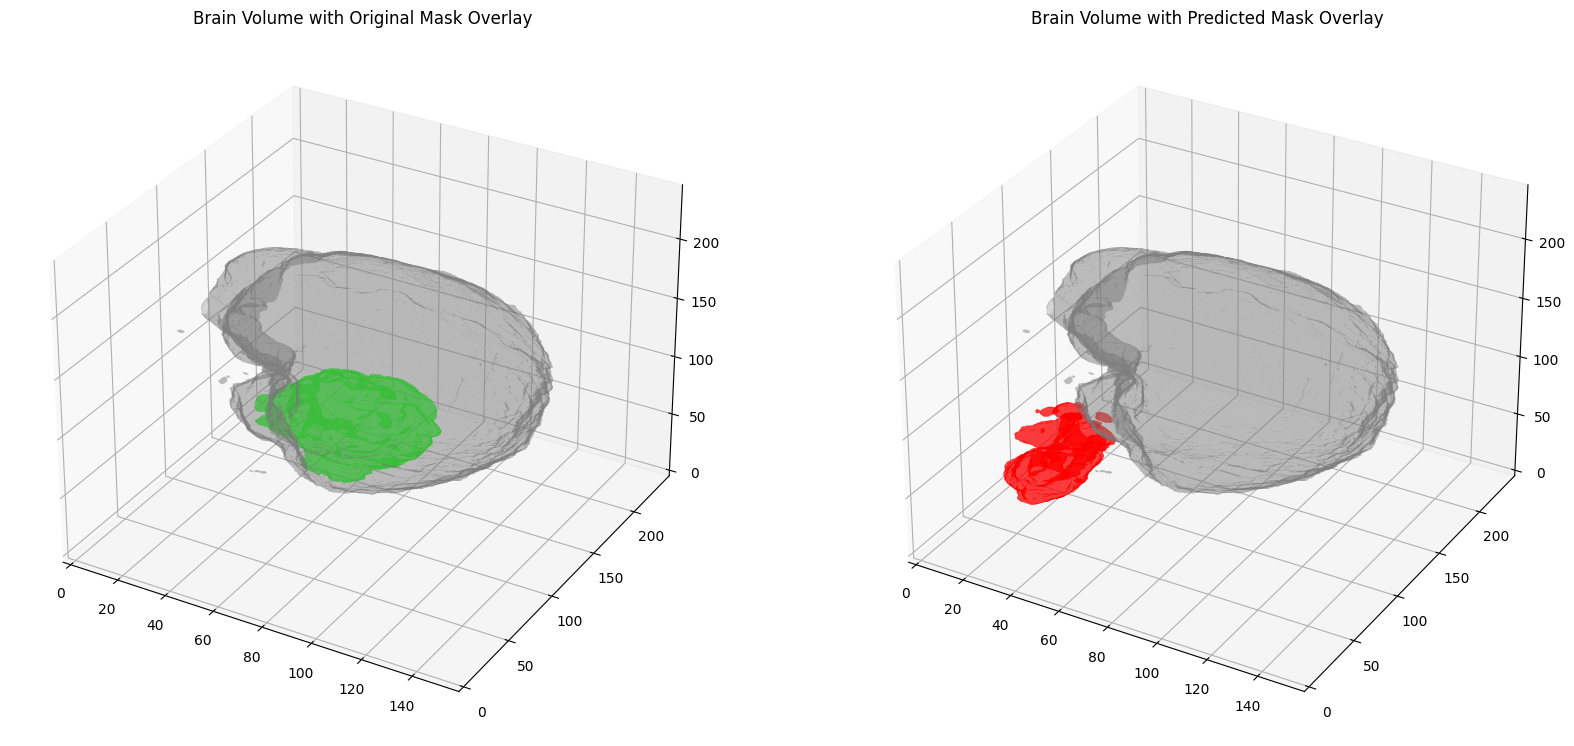

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.ndimage import zoom

def predict_mask(volume, model):
    """Predict segmentation mask for a single volume using the trained model."""
    resized_volume = zoom(volume, (128 / volume.shape[0], 128 / volume.shape[1], 64 / volume.shape[2]))
    resized_volume = np.expand_dims(resized_volume, axis=0)
    resized_volume = np.expand_dims(resized_volume, axis=-1)
    prediction = model.predict(resized_volume)
    predicted_mask = prediction[0, :, :, :, 0]
    return predicted_mask

def plot_3d_overlay(brain_volume, original_mask, predicted_mask, volume_threshold, mask_threshold=0.2):
    # Standardize transformations for visualization
    p_brain = brain_volume.transpose(2, 1, 0)
    p_brain = p_brain[:, :, ::-1]
    p_original_mask = original_mask.transpose(2, 1, 0)
    p_original_mask = p_original_mask[:, :, ::-1]
    p_predicted_mask = predicted_mask.transpose(2, 1, 0)
    p_predicted_mask = p_predicted_mask[:, :, ::-1]

    # Apply the same thresholding and binary masking
    p_original_mask = (p_original_mask > mask_threshold).astype(float)
    p_predicted_mask = (p_predicted_mask > mask_threshold).astype(float)

    fig = plt.figure(figsize=(20, 10))

    # Define fixed axis limits
    fixed_limits = ((0, p_brain.shape[0]), (0, p_brain.shape[1]), (0, p_brain.shape[2]))

    # Visualization settings
    alpha_value = 0.6  # uniform opacity for both masks

    # Original Mask Plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title('Brain Volume with Original Mask Overlay')
    ax1.set_xlim(*fixed_limits[0])
    ax1.set_ylim(*fixed_limits[1])
    ax1.set_zlim(*fixed_limits[2])

    verts, faces, _, _ = measure.marching_cubes(p_brain, level=volume_threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.3)
    mesh.set_facecolor([0.5, 0.5, 0.5])
    ax1.add_collection3d(mesh)

    verts, faces, _, _ = measure.marching_cubes(p_original_mask, level=0.5)
    mesh = Poly3DCollection(verts[faces], alpha=alpha_value, edgecolor='none')
    mesh.set_facecolor([0, 1, 0])
    ax1.add_collection3d(mesh)

    # Predicted Mask Plot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title('Brain Volume with Predicted Mask Overlay')
    ax2.set_xlim(*fixed_limits[0])
    ax2.set_ylim(*fixed_limits[1])
    ax2.set_zlim(*fixed_limits[2])

    verts, faces, _, _ = measure.marching_cubes(p_brain, level=volume_threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.3)
    mesh.set_facecolor([0.5, 0.5, 0.5])
    ax2.add_collection3d(mesh)

    verts, faces, _, _ = measure.marching_cubes(p_predicted_mask, level=0.5)
    mesh = Poly3DCollection(verts[faces], alpha=alpha_value, edgecolor='none')
    mesh.set_facecolor([1, 0, 0])
    ax2.add_collection3d(mesh)

    plt.show()



# Load model and data

volume = nib.load(image_files[4]).get_fdata()
original_mask = nib.load(mask_files[4]).get_fdata()

# Assuming normalization/preprocessing is done as necessary
predicted_mask = predict_mask(volume, model)

# Visualize
plot_3d_overlay(volume, original_mask > 0.8, predicted_mask > 0.1, volume_threshold=50, mask_threshold=0.1)


1/1 [==============================] - 0s 27ms/step


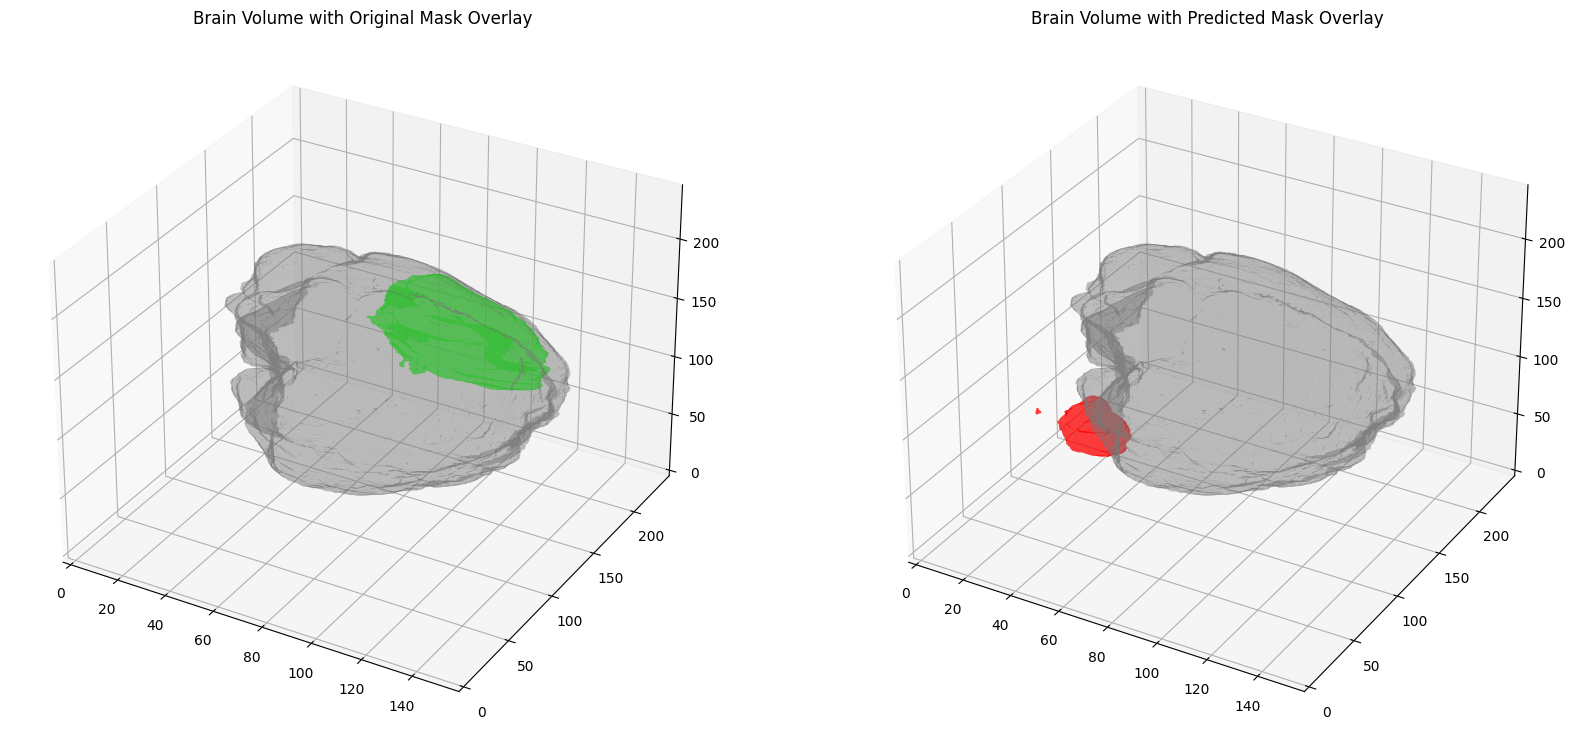

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.ndimage import zoom

def predict_mask(volume, model):
    """Predict segmentation mask for a single volume using the trained model."""
    resized_volume = zoom(volume, (128 / volume.shape[0], 128 / volume.shape[1], 64 / volume.shape[2]))
    resized_volume = np.expand_dims(resized_volume, axis=0)
    resized_volume = np.expand_dims(resized_volume, axis=-1)
    prediction = model.predict(resized_volume)
    predicted_mask = prediction[0, :, :, :, 0]
    return predicted_mask

def plot_3d_overlay(brain_volume, original_mask, predicted_mask, volume_threshold, mask_threshold=0.2):
    # Standardize transformations for visualization
    p_brain = brain_volume.transpose(2, 1, 0)
    p_brain = p_brain[:, :, ::-1]
    p_original_mask = original_mask.transpose(2, 1, 0)
    p_original_mask = p_original_mask[:, :, ::-1]
    p_predicted_mask = predicted_mask.transpose(2, 1, 0)
    p_predicted_mask = p_predicted_mask[:, :, ::-1]

    # Apply the same thresholding and binary masking
    p_original_mask = (p_original_mask > mask_threshold).astype(float)
    p_predicted_mask = (p_predicted_mask > mask_threshold).astype(float)

    fig = plt.figure(figsize=(20, 10))

    # Define fixed axis limits
    fixed_limits = ((0, p_brain.shape[0]), (0, p_brain.shape[1]), (0, p_brain.shape[2]))

    # Visualization settings
    alpha_value = 0.6  # uniform opacity for both masks

    # Original Mask Plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title('Brain Volume with Original Mask Overlay')
    ax1.set_xlim(*fixed_limits[0])
    ax1.set_ylim(*fixed_limits[1])
    ax1.set_zlim(*fixed_limits[2])

    verts, faces, _, _ = measure.marching_cubes(p_brain, level=volume_threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.3)
    mesh.set_facecolor([0.5, 0.5, 0.5])
    ax1.add_collection3d(mesh)

    verts, faces, _, _ = measure.marching_cubes(p_original_mask, level=0.5)
    mesh = Poly3DCollection(verts[faces], alpha=alpha_value, edgecolor='none')
    mesh.set_facecolor([0, 1, 0])
    ax1.add_collection3d(mesh)

    # Predicted Mask Plot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title('Brain Volume with Predicted Mask Overlay')
    ax2.set_xlim(*fixed_limits[0])
    ax2.set_ylim(*fixed_limits[1])
    ax2.set_zlim(*fixed_limits[2])

    verts, faces, _, _ = measure.marching_cubes(p_brain, level=volume_threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.3)
    mesh.set_facecolor([0.5, 0.5, 0.5])
    ax2.add_collection3d(mesh)

    verts, faces, _, _ = measure.marching_cubes(p_predicted_mask, level=0.5)
    mesh = Poly3DCollection(verts[faces], alpha=alpha_value, edgecolor='none')
    mesh.set_facecolor([1, 0, 0])
    ax2.add_collection3d(mesh)

    plt.show()



# Load model and data

volume = nib.load(image_file).get_fdata()
original_mask = nib.load(mask_file).get_fdata()

# Assuming normalization/preprocessing is done as necessary
predicted_mask = predict_mask(volume, model)

# Visualize
plot_3d_overlay(volume, original_mask > 0.8, predicted_mask > 0.05, volume_threshold=50, mask_threshold=0.1)


In [ ]:
print(mask_files)

['/content/bratsData/BraTS2021_00003/BraTS2021_00003_seg.nii.gz', '/content/bratsData/BraTS2021_00009/BraTS2021_00009_seg.nii.gz', '/content/bratsData/BraTS2021_00017/BraTS2021_00017_seg.nii.gz', '/content/bratsData/BraTS2021_00018/BraTS2021_00018_seg.nii.gz', '/content/bratsData/BraTS2021_00019/BraTS2021_00019_seg.nii.gz', '/content/bratsData/BraTS2021_00021/BraTS2021_00021_seg.nii.gz', '/content/bratsData/BraTS2021_00022/BraTS2021_00022_seg.nii.gz', '/content/bratsData/BraTS2021_00024/BraTS2021_00024_seg.nii.gz', '/content/bratsData/BraTS2021_00030/BraTS2021_00030_seg.nii.gz', '/content/bratsData/BraTS2021_00032/BraTS2021_00032_seg.nii.gz', '/content/bratsData/BraTS2021_00036/BraTS2021_00036_seg.nii.gz', '/content/bratsData/BraTS2021_00044/BraTS2021_00044_seg.nii.gz', '/content/bratsData/BraTS2021_00045/BraTS2021_00045_seg.nii.gz', '/content/bratsData/BraTS2021_00049/BraTS2021_00049_seg.nii.gz', '/content/bratsData/BraTS2021_00053/BraTS2021_00053_seg.nii.gz', '/content/bratsData/BraT

In [ ]:
image_file = '/content/bratsData/BraTS2021_00495/BraTS2021_00495_flair.nii.gz'
mask_file = '/content/bratsData/BraTS2021_00495/BraTS2021_00495_seg.nii.gz'

1/1 [==============================] - 3s 3s/step


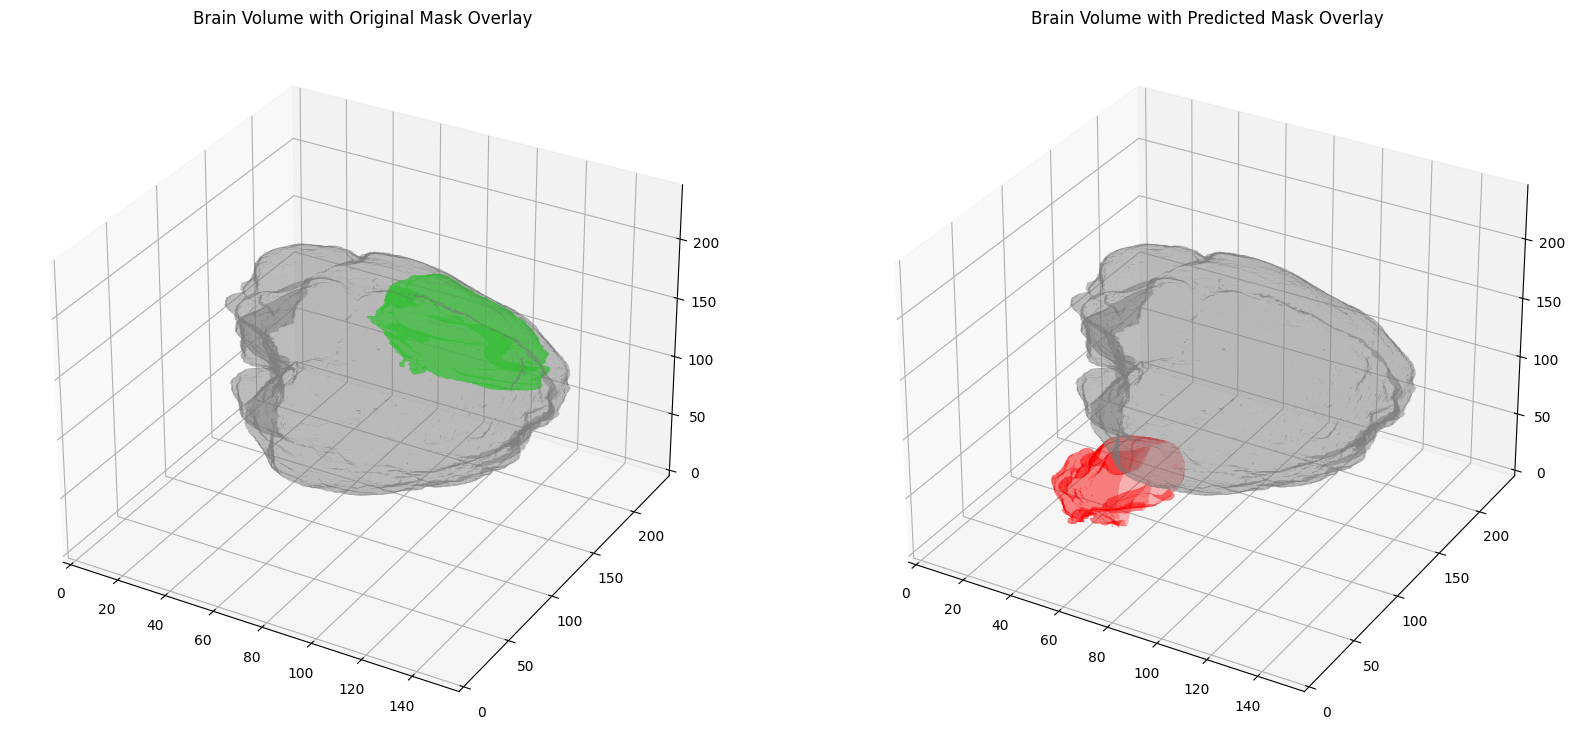

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.ndimage import zoom
import nibabel as nib

def predict_mask(volume, model):
    """Predict segmentation mask for a single volume using the trained model."""
    resized_volume = zoom(volume, (128 / volume.shape[0], 128 / volume.shape[1], 64 / volume.shape[2]))
    resized_volume = np.expand_dims(resized_volume, axis=0)
    resized_volume = np.expand_dims(resized_volume, axis=-1)
    prediction = model.predict(resized_volume)
    predicted_mask = prediction[0, :, :, :, 0]
    return predicted_mask

def plot_3d_overlay(brain_volume, original_mask, predicted_mask, original_coordinates, volume_threshold, original_alpha, predicted_alpha):
    # Standardize transformations for visualization
    p_brain = brain_volume.transpose(2, 1, 0)
    p_brain = p_brain[:, :, ::-1]
    p_original_mask = original_mask.transpose(2, 1, 0)
    p_original_mask = p_original_mask[:, :, ::-1]
    p_predicted_mask = predicted_mask.transpose(2, 1, 0)
    p_predicted_mask = p_predicted_mask[:, :, ::-1]

    fig = plt.figure(figsize=(20, 10))

    # Define fixed axis limits
    fixed_limits = ((0, p_brain.shape[0]), (0, p_brain.shape[1]), (0, p_brain.shape[2]))

    # Visualization settings
    alpha_value = 0.6  # uniform opacity for both masks

    # Original Mask Plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title('Brain Volume with Original Mask Overlay')
    ax1.set_xlim(*fixed_limits[0])
    ax1.set_ylim(*fixed_limits[1])
    ax1.set_zlim(*fixed_limits[2])

    verts, faces, _, _ = measure.marching_cubes(p_brain, level=volume_threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.3)
    mesh.set_facecolor([0.5, 0.5, 0.5])
    ax1.add_collection3d(mesh)

    verts, faces, _, _ = measure.marching_cubes(p_original_mask, level=0.5)
    mesh = Poly3DCollection(verts[faces], alpha=original_alpha, edgecolor='none')
    mesh.set_facecolor([0, 1, 0])
    ax1.add_collection3d(mesh)

    # Display predicted mask at original coordinates


    # Calculate translation vector from original to predicted coordinates
    translation_vector = calculate_translation_vector(original_coordinates, predicted_coordinates)

    # Predicted Mask Plot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title('Brain Volume with Predicted Mask Overlay')
    ax2.set_xlim(*fixed_limits[0])
    ax2.set_ylim(*fixed_limits[1])
    ax2.set_zlim(*fixed_limits[2])

    verts, faces, _, _ = measure.marching_cubes(p_brain, level=volume_threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.3)
    mesh.set_facecolor([0.5, 0.5, 0.5])
    ax2.add_collection3d(mesh)

    # Translate the predicted mask to the original coordinates
    translated_predicted_mask = np.zeros_like(p_predicted_mask)
    for coord in original_coordinates:
        translated_coord = tuple(map(int, coord + translation_vector))  # Cast coordinates to integers
        if all(c >= 0 and c < translated_predicted_mask.shape[i] for i, c in enumerate(translated_coord)):
            translated_predicted_mask[translated_coord] = 1

    verts, faces, _, _ = measure.marching_cubes(translated_predicted_mask, level=0.5)
    mesh = Poly3DCollection(verts[faces], alpha=predicted_alpha, edgecolor='none')
    mesh.set_facecolor([1, 0, 0])
    ax2.add_collection3d(mesh)

    plt.show()

def calculate_translation_vector(original_coords, predicted_coords):
    """Calculate translation vector from original coordinates to predicted coordinates."""
    original_center = np.mean(original_coords, axis=0)
    predicted_center = np.mean(predicted_coords, axis=0)
    translation_vector = predicted_center - original_center
    return translation_vector

def extract_3d_mask_coordinates(mask_data):
    """Extract non-zero coordinates from the mask."""
    return np.argwhere(mask_data > 0)

# Usage example
volume = nib.load(image_file).get_fdata()
original_mask_data = nib.load(mask_file).get_fdata()  # Load mask data

# Assuming normalization/preprocessing is done as necessary
predicted_mask = predict_mask(volume, model)

# Extract coordinates of original mask
original_coordinates = extract_3d_mask_coordinates(original_mask_data)  # Pass mask data

# Extract coordinates of predicted mask
predicted_coordinates = extract_3d_mask_coordinates(predicted_mask > 0.1)  # Threshold predicted mask

# Visualize
plot_3d_overlay(volume, original_mask_data > 0.8, predicted_mask > 0.02, original_coordinates, volume_threshold=50, original_alpha=0.6, predicted_alpha=0.3)


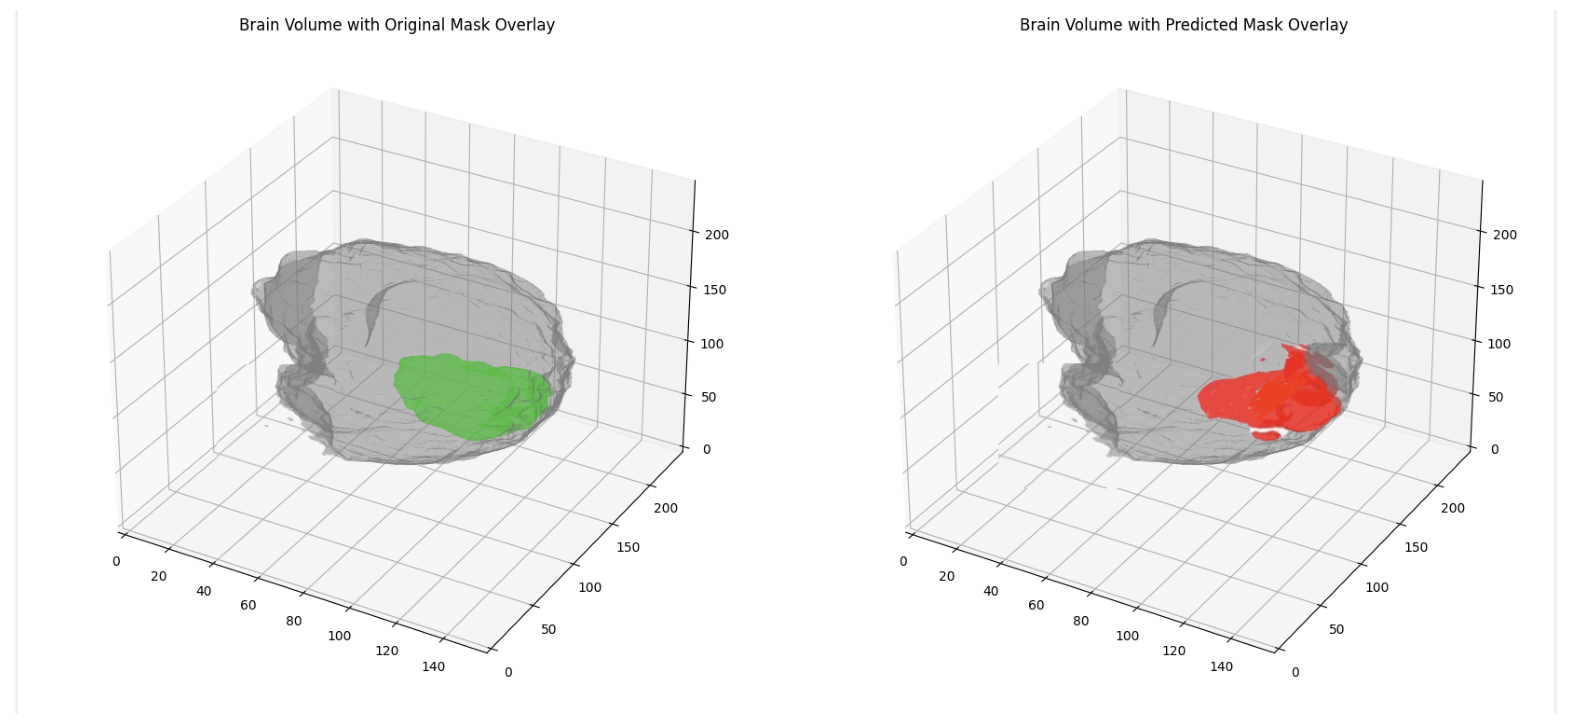

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.ndimage import zoom

def predict_mask(volume, model):
    """Predict segmentation mask for a single volume using the trained model."""
    resized_volume = zoom(volume, (128 / volume.shape[0], 128 / volume.shape[1], 64 / volume.shape[2]))
    resized_volume = np.expand_dims(resized_volume, axis=0)
    resized_volume = np.expand_dims(resized_volume, axis=-1)
    prediction = model.predict(resized_volume)
    predicted_mask = prediction[0, :, :, :, 0]
    return predicted_mask
image = mpimg.imread('/content/MLHpatient0.png')

def plot_3d_overlay(brain_volume, original_mask, predicted_mask, volume_threshold, mask_threshold=0.2):
    # Standardize transformations for visualization
    p_brain = brain_volume.transpose(2, 1, 0)
    p_brain = p_brain[:, :, ::-1]
    p_original_mask = original_mask.transpose(2, 1, 0)
    p_original_mask = p_original_mask[:, :, ::-1]
    p_predicted_mask = predicted_mask.transpose(2, 1, 0)
    p_predicted_mask = p_predicted_mask[:, :, ::-1]

    # Apply the same thresholding and binary masking
    p_original_mask = (p_original_mask > mask_threshold).astype(float)
    p_predicted_mask = (p_predicted_mask > mask_threshold).astype(float)

    fig = plt.figure(figsize=(20, 10))

    # Define fixed axis limits
    fixed_limits = ((0, p_brain.shape[0]), (0, p_brain.shape[1]), (0, p_brain.shape[2]))

    # Visualization settings
    alpha_value = 0.6  # uniform opacity for both masks

    # Original Mask Plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title('Brain Volume with Original Mask Overlay')
    ax1.set_xlim(*fixed_limits[0])
    ax1.set_ylim(*fixed_limits[1])
    ax1.set_zlim(*fixed_limits[2])

    verts, faces, _, _ = measure.marching_cubes(p_brain, level=volume_threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.3)
    mesh.set_facecolor([0.5, 0.5, 0.5])
    ax1.add_collection3d(mesh)

    verts, faces, _, _ = measure.marching_cubes(p_original_mask, level=0.5)
    mesh = Poly3DCollection(verts[faces], alpha=alpha_value, edgecolor='none')
    mesh.set_facecolor([0, 1, 0])
    ax1.add_collection3d(mesh)

    # Predicted Mask Plot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title('Brain Volume with Predicted Mask Overlay')
    ax2.set_xlim(*fixed_limits[0])
    ax2.set_ylim(*fixed_limits[1])
    ax2.set_zlim(*fixed_limits[2])

    verts, faces, _, _ = measure.marching_cubes(p_brain, level=volume_threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.3)
    mesh.set_facecolor([0.5, 0.5, 0.5])
    ax2.add_collection3d(mesh)

    verts, faces, _, _ = measure.marching_cubes(p_predicted_mask, level=0.5)
    mesh = Poly3DCollection(verts[faces], alpha=alpha_value, edgecolor='none')
    mesh.set_facecolor([1, 0, 0])
    ax2.add_collection3d(mesh)

    plt.show()

plt.figure(figsize=(20, 10))

plt.imshow(image)
plt.axis('off')
plt.show()